# Noisy GP Experiments

In [204]:
import numpy as np
import numba
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.utils import check_random_state, check_array, check_X_y
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import check_pairwise_arrays, euclidean_distances
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import _check_length_scale, WhiteKernel, RBF, ConstantKernel as C
from scipy import interpolate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
mpl.rcParams['savefig.pad_inches'] = 0

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1D Toy Example

In [205]:
figure_location = '/home/emmanuel/projects/2018_igarss/figures/noisy_gp/1d_example/'
figure_location = '/Users/eman/Documents/code_projects/gaussian_processes/pkg_sgpuppy/figures/'
figure_location = '/home/emmanuel/projects/gaussian_processes/pkg_sgpuppy/figures/'

In [206]:
weights = {}
predictions = {}
variance = {}
mae = {}
mse = {}
rmse = {}

### Sample Data

In [207]:
seed = 123
rng = np.random.RandomState(seed=seed)

# sample data parameters
n_train, n_test, n_trial = 60, 100, 1000
sigma_y = 0.05
x_cov = 0.3
y_scale = .5
x_min, x_max = -10, 10

# real function
f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + y_scale * x))
# f = lambda x: np.sinc(x)
# f = lambda x: np.sin(2. * x) + np.exp(0.2 * x)


# Training add x, y = f(x)
x = np.linspace(x_min, x_max, n_train + n_test)


x, xs, = train_test_split(x, train_size=n_train, random_state=seed)

# add noise
y = f(x)
x_train = x + x_cov * rng.randn(n_train)
y_train = f(x) + sigma_y * rng.randn(n_train)

x_train, y_train = x_train[:, np.newaxis], y_train[:, np.newaxis]



# -----------------
# Testing Data
# -----------------

ys = f(xs)

# Add noise
x_test = xs + x_cov * rng.randn(n_test)
y_test = ys

x_test, y_test = x_test[:, np.newaxis], y_test[:, np.newaxis]

# -------------------
# Plot Points
# -------------------
x_plot = np.linspace(x_min, x_max, n_test)[:, None]
y_plot = f(x_plot)

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [208]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, x_test.shape)

(60,) (60,)
(60, 1) (60, 1)
(100, 1) (100, 1)


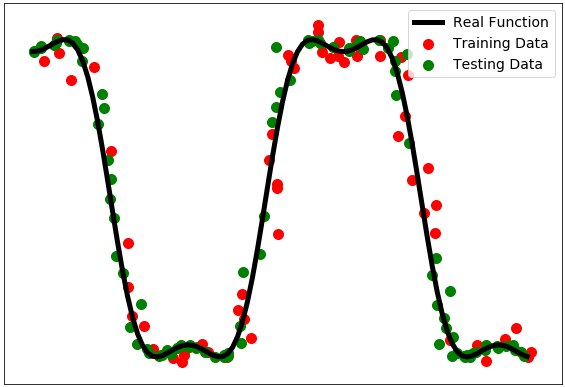

In [209]:
# plot toy data
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, y_plot, linewidth=5, color='k', label='Real Function')
ax.scatter(x_train, y_train, color='r', s=100, label='Training Data')
ax.scatter(x_test, y_test, color='g', s=100, label='Testing Data')

# ax.set_title('Training and Testing Data', fontsize=20)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

save_name = 'training_data.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Naive GP Implementation (to Find Suitable Hyperparameters)

In [210]:
def fit_gp(x_train, y_train, kernel='ard', scale=None,
           length_scale_bounds = (0.001, 100),
           noise_level_bounds = (1e-4, 10),
           n_restarts=3):
    
    warnings.simplefilter('ignore')
    x_train, y_train = check_X_y(x_train, y_train)
    warnings.simplefilter('default')
    n_train, d_dims = x_train.shape
    
    if kernel in ['ard', 'ARD']:
        length_scale_init = np.ones(shape=(d_dims))
    elif kernel in ['rbf', 'RBF']:
        length_scale_init = 1.0
    else:
        raise ValueError('Unrecognized kernel function...')
    
    noise_level_init = 1.0

    gp_kernel = C() * RBF(length_scale=length_scale_init,
                    length_scale_bounds=length_scale_bounds) + \
                WhiteKernel(noise_level=noise_level_init,
                            noise_level_bounds=noise_level_bounds)
    
    gpr_model = GaussianProcessRegressor(kernel=gp_kernel, random_state=123,
                                         n_restarts_optimizer=n_restarts)
    
    # Fit the GP Model
    gpr_model.fit(x_train, y_train)
    
    # the parameters
    
    constant = gpr_model.kernel_.get_params()['k1__k1__constant_value']
    length_scale = gpr_model.kernel_.get_params()['k1__k2__length_scale']
    sigma = gpr_model.kernel_.get_params()['k2__noise_level']
    
    return length_scale, sigma, constant

In [211]:
length_scale, sigma_y, constant = fit_gp(x_train, y_train, n_restarts=0)
print('Length Scale: {:.3f}'.format(length_scale))
print('Likelihood Variance:: {:.3f}'.format(sigma_y))
print('Signal Variance: {:.3f}'.format(constant))

Length Scale: 1.876
Likelihood Variance:: 0.032
Signal Variance: 0.625


## Gaussian Covariance Function (ARD/RBF Kernel)

\begin{equation}
    K(x, y) = \nu \cdot \text{exp} \left[ -\frac{1}{2} (x - y)^{\top} \cdot W^{-1} \cdot (x - y) \right]
\end{equation}

* $W^{-1}= \text{diag}\left[ w_1, w_2, \ldots, w_{D} \right]$
* $w_d = \frac{1}{\lambda_d^2}$
* $\nu$ is the signal variance parameter

### GP/KRR Manually

In [212]:
from GaussianProcess import GaussianProcess
from Covariance import GaussianCovariance
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
w = np.array([length_scale])
v = constant
vt = sigma_y
Sigma = np.array([0.8])
if np.ndim(Sigma) == 1:
    Sigma = Sigma[:, np.newaxis]

# Preparing the parameter vector
theta = np.zeros(2+len(w))
theta[0] = np.log(v)  # We actually use the log of the parameters as it is easier to optimize (no > 0 constraint etc.)
theta[1] = np.log(vt)
theta[2:2+len(w)] = np.log(w)

# Simulating simulation data by drawing data from a random Gaussian process
t = GaussianProcess.get_realisation(x_train, GaussianCovariance(),theta)

# The regression step is pretty easy:
# Input data x (list of input vectors)
# Corresponding simulation output t (just a list of floats of the same length as x)
# Covariance function of your choice (only GaussianCovariance can be used for uncertainty propagation at the moment)
gp_est = GaussianProcess(x_train, y_train,GaussianCovariance());

[-0.44112603 -1.82742039 -4.57593713]
l_bfgs_b 	 0.07821846008300781 	 [[5.40878765]] 	 [-0.46299425 -3.43578278 -1.26032422]
[-0.46299425 -3.43578278 -1.26032422]


In [214]:
signal_variance = np.exp(-0.37193111)
sigma_y = np.exp(-4.3078261)
length_scale = np.exp(-1.25336646)
print('Length Scale: {:.3f}'.format(length_scale))
print('Likelihood Variance: {:.3f}'.format(sigma_y))
print('Signal Variance: {:.3f}'.format(signal_variance))


Length Scale: 0.286
Likelihood Variance: 0.013
Signal Variance: 0.689


In [215]:
%%time
# Initialize the GP and Fit the model
gp_model = GaussianProcess(x_train, y_train, GaussianCovariance());

# Predict
predictions['simple'], var = gp_model.estimate_many(x_test);

mae['simple'] = mean_absolute_error(predictions['simple'], y_test)
mse['simple'] = mean_squared_error(predictions['simple'], y_test)
rmse['simple'] = np.mean(np.sqrt(np.mean(predictions['simple'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['simple']))
print('MSE Score: {:.5f}'.format(mse['simple']))
print('RMSE Score: {:.5f}\n'.format(rmse['simple']))

[-0.44112603 -1.82742039 -4.57593713]
l_bfgs_b 	 0.07840895652770996 	 [[5.40878765]] 	 [-0.46299425 -3.43578278 -1.26032422]
[-0.46299425 -3.43578278 -1.26032422]

MAE Score: 0.11943
MSE Score: 0.03086
RMSE Score: 0.11943

CPU times: user 332 ms, sys: 2.38 s, total: 2.71 s
Wall time: 87.2 ms


#### Plot Simple GP Results

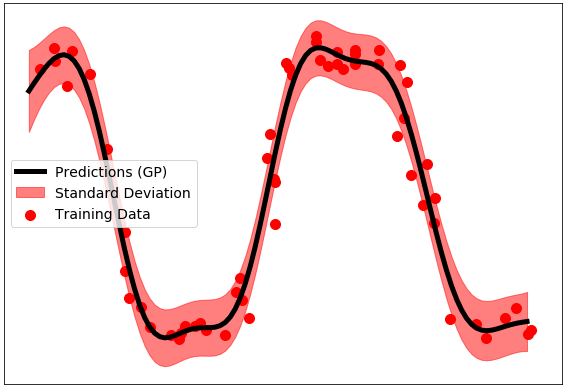

In [216]:
# Get Figure for x_plot
predictions['simple'], variance['simple'] = gp_model.estimate_many(x_plot)


# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['simple'], linewidth=5, color='k', label='Predictions (GP)')
ax.fill_between(x_plot.squeeze(), 
                predictions['simple'].squeeze() - np.sqrt(variance['simple']).squeeze(),
                predictions['simple'].squeeze() + np.sqrt(variance['simple']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_simple.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Uncertainty Propagation (Approximate)

In [217]:
from UncertaintyPropagation import UncertaintyPropagationApprox

In [218]:
%%time 

# Initialize GP
gp_approx = UncertaintyPropagationApprox(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['approx'] = np.zeros(n_samples)
var = np.zeros(n_samples)
print(x_test.shape)
for i in range(n_samples):
    predictions['approx'][i], var[i] = gp_approx.propagate_GA(x_test[i],Sigma)

mae['approx'] = mean_absolute_error(predictions['approx'], y_test)
mse['approx'] = mean_squared_error(predictions['approx'], y_test)
rmse['approx'] = np.mean(np.sqrt(np.mean(predictions['approx'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['approx']))
print('MSE Score: {:.5f}'.format(mse['approx']))
print('RMSE Score: {:.5f}\n'.format(rmse['approx']))

print(var.min(), var.max())

(100, 1)

MAE Score: 0.20186
MSE Score: 0.06471
RMSE Score: 0.82146

0.036741653658927065 0.6139305821447852
CPU times: user 4.74 s, sys: 9.14 ms, total: 4.75 s
Wall time: 4.74 s


##### Plot Derivative Term Results

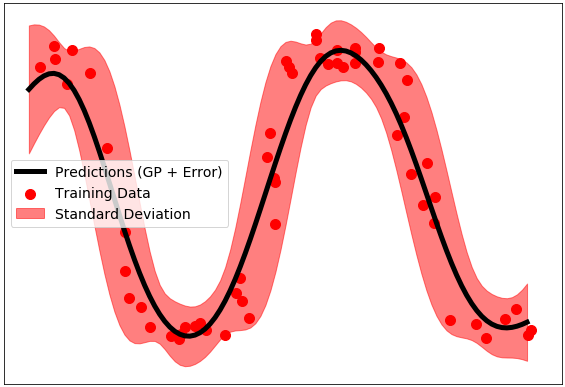

In [219]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['approx'] = np.zeros(n_samples)
variance['approx'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['approx'][i], variance['approx'][i] = gp_approx.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['approx'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['approx'].squeeze() - np.sqrt(variance['approx']).squeeze(),
                predictions['approx'].squeeze() + np.sqrt(variance['approx']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_approx.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Exact Uncertainty

In [220]:
from UncertaintyPropagation import UncertaintyPropagationExact

In [221]:
%%time
# Initialize GP
gp_exact = UncertaintyPropagationExact(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['exact'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['exact'][i], var[i] = gp_exact.propagate_GA(x_test[i],Sigma)
    
mae['exact'] = mean_absolute_error(predictions['exact'], y_test)
mse['exact'] = mean_squared_error(predictions['exact'], y_test)
rmse['exact'] = np.mean(np.sqrt(np.mean(predictions['exact'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['exact']))
print('MSE Score: {:.5f}'.format(mse['exact']))
print('RMSE Score: {:.5f}\n'.format(rmse['exact']))
print(var.min(), var.max())


MAE Score: 0.18252
MSE Score: 0.05489
RMSE Score: 0.82141

0.04327122495340241 0.37333558976418885
CPU times: user 7.11 s, sys: 1.02 s, total: 8.12 s
Wall time: 7.05 s


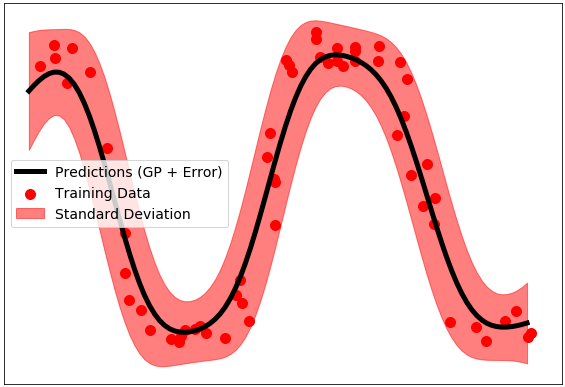

In [222]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['exact'] = np.zeros(n_samples)
variance['exact'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['exact'][i], variance['exact'][i] = gp_exact.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['exact'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['exact'].squeeze() - np.sqrt(variance['exact']).squeeze(),
                predictions['exact'].squeeze() + np.sqrt(variance['exact']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_exact.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Exact Numerical Uncertainty MCMC

In [223]:
from UncertaintyPropagation import UncertaintyPropagationMC

In [224]:
%%time
# Initialize GP
gp_stat = UncertaintyPropagationMC(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['stat'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['stat'][i], var[i] = gp_stat.propagate_GA(x_test[i],Sigma)
    
mae['stat'] = mean_absolute_error(predictions['stat'], y_test)
mse['stat'] = mean_squared_error(predictions['stat'], y_test)
rmse['stat'] = np.mean(np.sqrt(np.mean(predictions['stat'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['stat']))
print('MSE Score: {:.5f}'.format(mse['stat']))
print('RMSE Score: {:.5f}\n'.format(rmse['stat']))

print(var.min(), var.max())


MAE Score: 0.18256
MSE Score: 0.05492
RMSE Score: 0.82134

0.030743063255165626 0.3787898885291527
CPU times: user 34.6 s, sys: 0 ns, total: 34.6 s
Wall time: 34.6 s


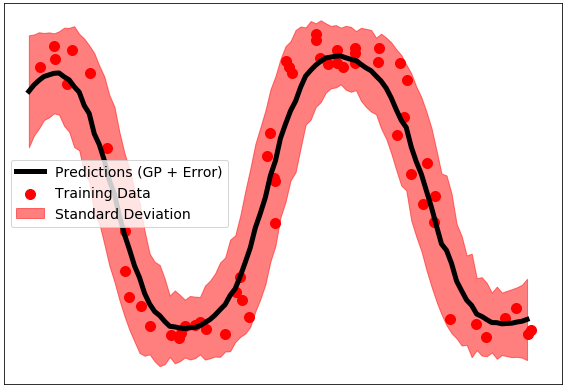

In [225]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['stat'] = np.zeros(n_samples)
variance['stat'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['stat'][i], variance['stat'][i] = gp_stat.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['stat'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['stat'].squeeze() - np.sqrt(variance['stat']).squeeze(),
                predictions['stat'].squeeze() + np.sqrt(variance['stat']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_stat.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Numerical

In [226]:
from UncertaintyPropagation import UncertaintyPropagationNumericalHG

In [227]:
%%time
# Initialize GP
gp_numerical = UncertaintyPropagationNumericalHG(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['numerical'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['numerical'][i], var[i] = gp_numerical.propagate_GA(x_test[i],Sigma)
    
mae['numerical'] = mean_absolute_error(predictions['numerical'], y_test)
mse['numerical'] = mean_squared_error(predictions['numerical'], y_test)
rmse['numerical'] = np.mean(np.sqrt(np.mean(predictions['numerical'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['numerical']))
print('MSE Score: {:.5f}'.format(mse['numerical']))
print('RMSE Score: {:.5f}\n'.format(rmse['numerical']))
print(var.min(), var.max())


MAE Score: 0.18268
MSE Score: 0.05498
RMSE Score: 0.82141

0.04295654971194218 0.38347543744936263
CPU times: user 390 ms, sys: 739 µs, total: 391 ms
Wall time: 390 ms


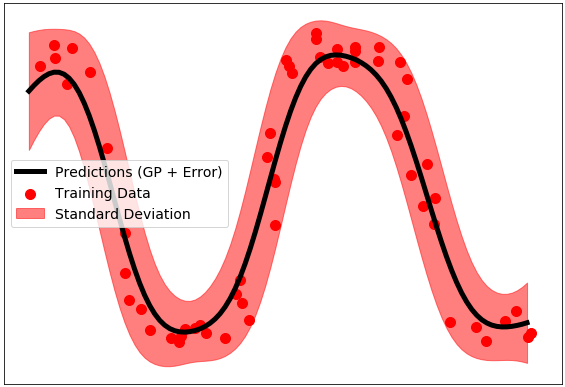

In [228]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['numerical'] = np.zeros(n_samples)
variance['numerical'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['numerical'][i], variance['numerical'][i] = gp_numerical.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['numerical'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['numerical'].squeeze() - np.sqrt(variance['numerical']).squeeze(),
                predictions['numerical'].squeeze() + np.sqrt(variance['numerical']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_numerical.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Empirical Variance Comparison


In [192]:
from sklearn.externals.joblib import Parallel, delayed

In [193]:
def generate_batches(n_samples, batch_size):
    """A generator to split an array of 0 to n_samples
    into an array of batch_size each.

    Parameters
    ----------
    n_samples : int
        the number of samples

    batch_size : int,
        the size of each batch


    Returns
    -------
    start_index, end_index : int, int
        the start and end indices for the batch

    Source:
        https://github.com/scikit-learn/scikit-learn/blob/master
        /sklearn/utils/__init__.py#L374
    """
    start_index = 0

    # calculate number of batches
    n_batches = int(n_samples // batch_size)

    for _ in range(n_batches):

        # calculate the end coordinate
        end_index = start_index + batch_size

        # yield the start and end coordinate for batch
        yield start_index, end_index

        # start index becomes new end index
        start_index = end_index

    # special case at the end of the segment
    if start_index < n_samples:

        # yield the remaining indices
        yield start_index, n_samples

In [194]:
def gperror_parallel(model, data, sigma, n_jobs=2, verbose=1, batch_size=20):
    
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(gperror_predict)(
            model, data[start:end], sigma)
        for (start, end) in generate_batches(data.shape[0], batch_size=batch_size)
    )
    # Aggregate results 
    mean, variance = tuple(zip(*results))
    mean = np.hstack(mean)
    variance = np.hstack(variance)
    
    return mean, variance

def gperror_predict(model, x, sigma):
    n_samples = len(x)
    mean, variance = np.zeros(n_samples), np.zeros(n_samples)
    
    for i in range(n_samples):
        mean[i], variance[i] = model(x[i], sigma)
    
    return mean, variance

### Calculate the Empirical Variance (Get Scores)

In [264]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error
rng = np.random.RandomState(None)
n_trials = 100
n_trial = 1000

mae_score = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

mse_score = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

abs_error = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}
squared_error = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

# testing set (noise-less)
ys = f(xt)
y_test = ys.squeeze()
y_test += sigma_y * rng.randn(n_trial)
y_test = np.atleast_2d(y_test).T
xt = np.linspace(x_min, x_max, n_trial)# fig, ax = plt.subplots()
batch_size = 20
n_jobs = 20


for itrial in range(n_trials):
    if itrial % 10 == 0:
        print('Trial: {}'.format(itrial+1))
    
    # Generate x samples with random error
    x_test = xt + 0.3 * rng.randn(n_trial)
    x_test = x_test[:, np.newaxis]
    n_samples = len(x_test)
#     ax.scatter(x_test, y_test)

    
    # -------------------
    # Model I - Simple GP
    # -------------------
    mean, _ = gp_model.estimate_many(x_test)
    
    abs_error['simple'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['simple'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['simple'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['simple'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))
    
    # -------------------
    # Model II - Approx
    # -------------------
    mean, _ = gperror_parallel(gp_approx.propagate_GA, x_test, Sigma, 
                               n_jobs=n_jobs, batch_size=batch_size, verbose=0)
#     break
#     mean = np.zeros(n_samples)
#     for i in range(n_samples):
        
#         mean[i], _ = gp_approx.propagate_GA(x_test[i],Sigma)
    
    abs_error['approx'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['approx'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['approx'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['approx'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))

    # -------------------
    # Model III - Exact
    # -------------------
    mean, _ = gperror_parallel(gp_exact.propagate_GA, x_test, Sigma, 
                               n_jobs=n_jobs, batch_size=batch_size, verbose=0)
#     mean = np.zeros(n_samples)
#     for i in range(n_samples):
        
#         mean[i], _ = gp_exact.propagate_GA(x_test[i],Sigma)
    
    abs_error['exact'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['exact'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['exact'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['exact'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))   

#     # -------------------
#     # Model IV - Numerical
#     # -------------------
#     mean, _ = gperror_parallel(gp_stat.propagate_GA, x_test, Sigma, 
#                                n_jobs=32, batch_size=batch_size, verbose=0)
    
#     abs_error['stat'].append(np.abs(mean.squeeze() - y_test.squeeze()))
#     squared_error['stat'].append((mean.squeeze() - y_test.squeeze())**2)  
#     mae_score['stat'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
#     mse_score['stat'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))

    # -------------------
    # Model IV - Numerical
    # -------------------
    mean, _ = gperror_parallel(gp_numerical.propagate_GA, x_test, Sigma, 
                               n_jobs=n_jobs, batch_size=batch_size, verbose=0)
#     mean = np.zeros(n_samples)
#     for i in range(n_samples):
        
#         mean[i], _ = gp_numerical.propagate_GA(x_test[i],Sigma)
    
    abs_error['numerical'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['numerical'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['numerical'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['numerical'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))
    

Trial: 1
Trial: 11
Trial: 21
Trial: 31
Trial: 41
Trial: 51
Trial: 61
Trial: 71
Trial: 81
Trial: 91
CPU times: user 1min 44s, sys: 15min 14s, total: 16min 59s
Wall time: 16min 19s


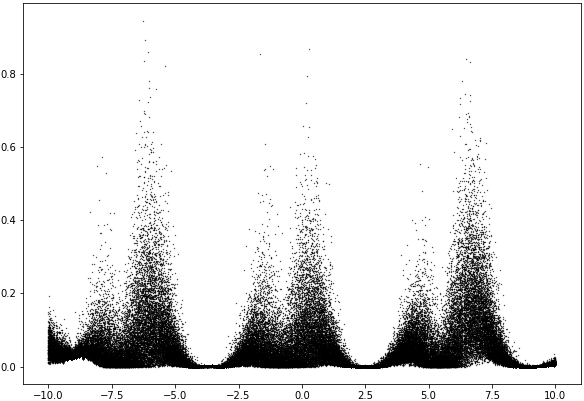

In [266]:
fig, ax = plt.subplots(figsize=(10, 7))

for sq_err in squared_error['numerical']:
    ax.scatter(xt, sq_err, s=0.1, color='k')
plt.show()

In [267]:
abs_error['simple'] = np.array(abs_error['simple'])
squared_error['simple'] = np.array(squared_error['simple'])
mae_score['simple'] = np.array(mae_score['simple'])
mse_score['simple'] = np.array(mse_score['simple'])

abs_error['approx'] = np.array(abs_error['approx'])
squared_error['approx'] = np.array(squared_error['approx'])
mae_score['approx'] =np.array(mae_score['approx'])
mse_score['approx'] = np.array(mse_score['approx'])

abs_error['exact'] = np.array(abs_error['exact'])
squared_error['exact'] = np.array(squared_error['exact'])
mae_score['exact'] = np.array(mae_score['exact'])
mse_score['exact'] = np.array(mse_score['exact'])

# abs_error['stat'] = np.mean(np.array(abs_error['stat']).squeeze(), axis=0)
# squared_error['stat'] = np.mean(np.array(squared_error['stat']).squeeze(), axis=0)
# mae_score['stat'] = np.mean(np.array(mae_score['stat']))
# mse_score['stat'] = np.mean(np.array(mse_score['stat']))
                       
abs_error['numerical'] = np.array(abs_error['numerical'])
squared_error['numerical'] = np.array(squared_error['numerical'])
mae_score['numerical'] = np.array(mae_score['numerical'])
mse_score['numerical'] = np.array(mse_score['numerical'])

In [197]:
abs_error['simple'] = np.mean(np.array(abs_error['simple']).squeeze(), axis=0)
squared_error['simple'] = np.mean(np.array(squared_error['simple']).squeeze(), axis=0)
mae_score['simple'] = np.mean(np.array(mae_score['simple']))
mse_score['simple'] = np.mean(np.array(mse_score['simple']))

abs_error['approx'] = np.mean(np.array(abs_error['approx']).squeeze(), axis=0)
squared_error['approx'] = np.mean(np.array(squared_error['approx']).squeeze(), axis=0)
mae_score['approx'] = np.mean(np.array(mae_score['approx']))
mse_score['approx'] = np.mean(np.array(mse_score['approx']))

abs_error['exact'] = np.mean(np.array(abs_error['exact']).squeeze(), axis=0)
squared_error['exact'] = np.mean(np.array(squared_error['exact']).squeeze(), axis=0)
mae_score['exact'] = np.mean(np.array(mae_score['exact']))
mse_score['exact'] = np.mean(np.array(mse_score['exact']))

# abs_error['stat'] = np.mean(np.array(abs_error['stat']).squeeze(), axis=0)
# squared_error['stat'] = np.mean(np.array(squared_error['stat']).squeeze(), axis=0)
# mae_score['stat'] = np.mean(np.array(mae_score['stat']))
# mse_score['stat'] = np.mean(np.array(mse_score['stat']))
                       
abs_error['numerical'] = np.mean(np.array(abs_error['numerical']).squeeze(), axis=0)
squared_error['numerical'] = np.mean(np.array(squared_error['numerical']).squeeze(), axis=0)
mae_score['numerical'] = np.mean(np.array(mae_score['numerical']))
mse_score['numerical'] = np.mean(np.array(mse_score['numerical']))

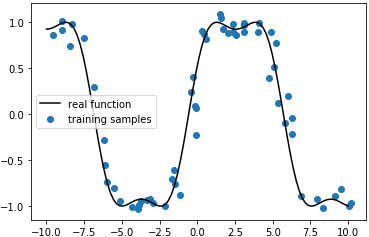

In [268]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, label='training samples')
ax.plot(x_plot, f(x_plot), color='black', label='real function')
ax.legend()
plt.show()
# ax.scatter(xs, abs_error['simple'], color='green', label='Empirical Absolute Error (Points)')

### No Uncertainty

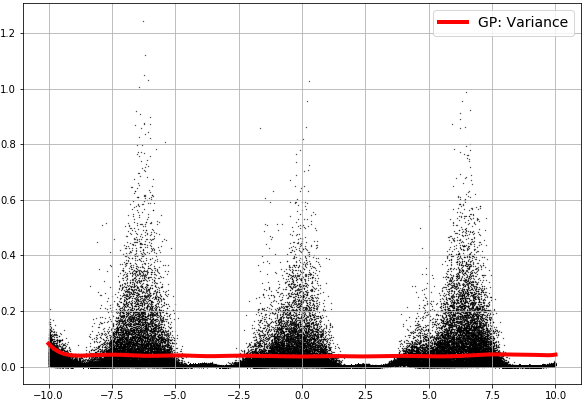

In [269]:
pred, var = gp_model.estimate_many(xt[:, np.newaxis])

# pred, var = gp_simple.predict(xt[:, np.newaxis], return_variance=True)

fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

for sq_err in squared_error['simple']:
    
    ax.scatter(xt, sq_err, s=0.1, color='k')
# ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')


ax.plot(xt, var, linewidth=4, color='r', label='GP: Variance')
# ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()


save_name = 'exp_empirical_simple_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


MSE: 0.03105
MAE: 0.11848


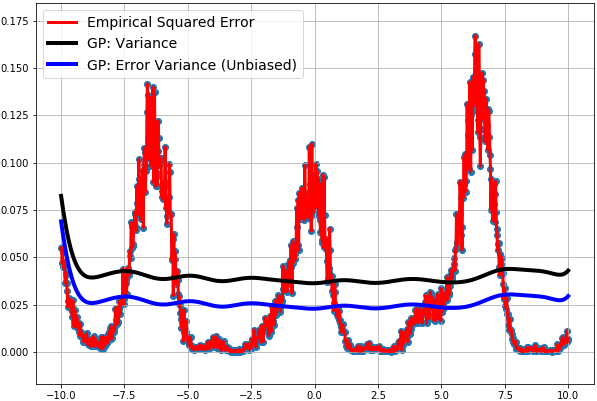

CPU times: user 1.53 s, sys: 10.9 s, total: 12.4 s
Wall time: 766 ms


In [229]:
%%time

xt = np.linspace(x_min, x_max, n_trial)# fig, ax = plt.subplots()

xnew = np.linspace(xt.min(), xt.max(), 1000)


# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['simple'], kind='quadratic')(xnew)

print('MSE: {:.5f}'.format(mse_score['simple']))
print('MAE: {:.5f}'.format(mae_score['simple']))

pred, var = gp_model.estimate_many(xt[:, np.newaxis])

# pred, var = gp_simple.predict(xt[:, np.newaxis], return_variance=True)

fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.scatter(xt, squared_error['simple'])
ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Variance')
ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()


save_name = 'exp_empirical_simple_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)




## Approximate Uncertainty

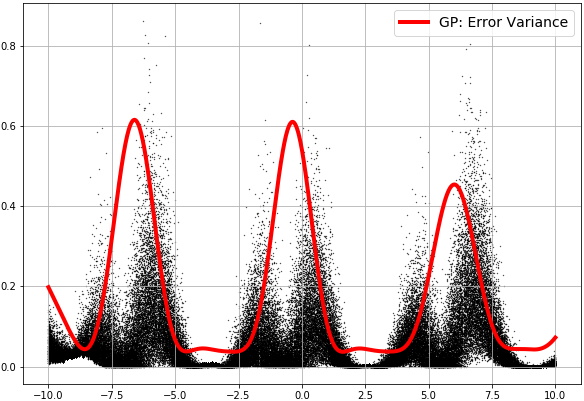

CPU times: user 2.79 s, sys: 7.77 s, total: 10.6 s
Wall time: 6.35 s


In [270]:
%%time


n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]
pred, var = gperror_parallel(gp_approx.propagate_GA, xt_, Sigma, 
                           n_jobs=n_jobs, batch_size=batch_size, verbose=0)
# for i in range(n_samples):
#     pred[i], var[i] = gp_approx.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)





fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

for sq_err in squared_error['approx']:
    ax.scatter(xt, sq_err, s=0.1, color='k')


# ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='r', label='GP: Error Variance')
# ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')


# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_approx_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


MSE: 0.05550
MAE: 0.18456


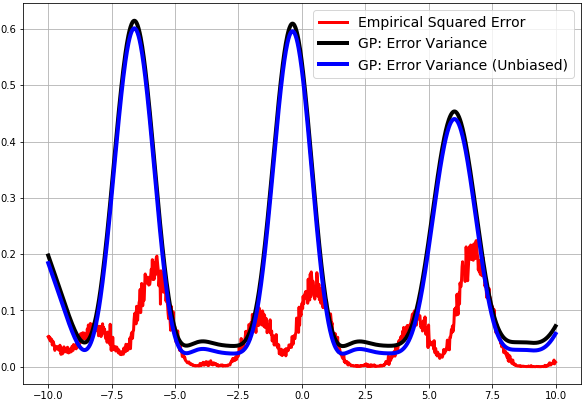

CPU times: user 1.16 s, sys: 6.59 s, total: 7.75 s
Wall time: 4.68 s


In [230]:
%%time

xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['approx'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['approx'], kind='quadratic')(xnew)

print('MSE: {:.5f}'.format(mse_score['approx']))
print('MAE: {:.5f}'.format(mae_score['approx']))

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]
pred, var = gperror_parallel(gp_approx.propagate_GA, xt_, Sigma, 
                           n_jobs=n_jobs, batch_size=batch_size, verbose=0)
# for i in range(n_samples):
#     pred[i], var[i] = gp_approx.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)





fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')
ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')


# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_approx_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Exact Uncertainty

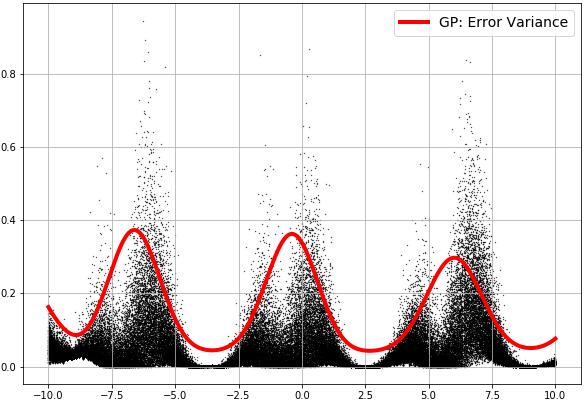

CPU times: user 2.46 s, sys: 7.76 s, total: 10.2 s
Wall time: 6.31 s


In [271]:
%%time


n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]
pred, var = gperror_parallel(gp_exact.propagate_GA, xt_, Sigma, 
                           n_jobs=n_jobs, batch_size=batch_size, verbose=0)
# for i in range(n_samples):
#     pred[i], var[i] = gp_exact.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)



fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

for sq_err in squared_error['exact']:
    ax.scatter(xt, sq_err, s=0.1, color='k')

ax.plot(xt, var, linewidth=4, color='r', label='GP: Error Variance')
# ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_exact_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

MSE: 0.04757
MAE: 0.16835


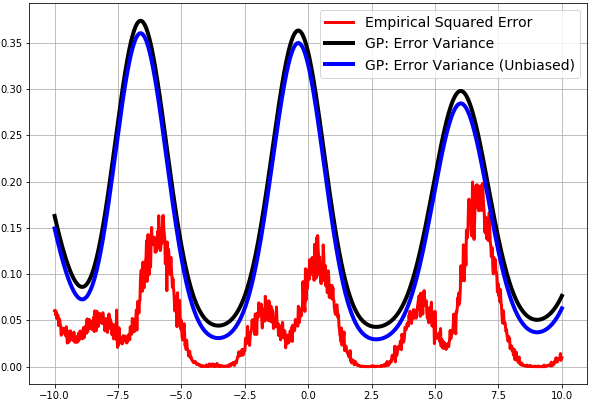

CPU times: user 1.1 s, sys: 6.52 s, total: 7.62 s
Wall time: 4.92 s


In [234]:
%%time

xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['exact'], kind='linear')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['exact'], kind='quadratic')(xnew)

print('MSE: {:.5f}'.format(mse_score['exact']))
print('MAE: {:.5f}'.format(mae_score['exact']))

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]
pred, var = gperror_parallel(gp_exact.propagate_GA, xt_, Sigma, 
                           n_jobs=n_jobs, batch_size=batch_size, verbose=0)
# for i in range(n_samples):
#     pred[i], var[i] = gp_exact.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)





fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')
ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_exact_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


## Numcerical Uncertainty (MC)

In [232]:
# xnew = np.linspace(xt.min(), xt.max(), 1000)

# abs_error_line = interpolate.interp1d(xt, abs_error['stat'], kind='quadratic')(xnew)

# # Interpolation function for squared error
# squared_error_line = interpolate.interp1d(xt, squared_error['stat'], kind='quadratic')(xnew)

# print('MSE: {:.5f}'.format(mse_score['stat']))
# print('MAE: {:.5f}'.format(mae_score['stat']))


# n_samples = len(xt)
# pred = np.zeros(n_samples)
# var = np.zeros(n_samples)
# xt_ = xt[:, np.newaxis]

# for i in range(n_samples):
#     pred[i], var[i] = gp_stat.propagate_GA(xt_[i], Sigma)
# # pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)




# fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

# ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
# ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')

# # ax.set_title('Squared Error, Variance')
# ax.legend(fontsize=14)
# # ax.get_xaxis().set_visible(False)
# # ax.get_yaxis().set_visible(False)
# ax.grid(True)
# plt.show()

# save_name = 'exp_empirical_stat_var.png'
# fig.savefig(figure_location + save_name, bbox_inhces='tight',
#             dpi=100, transparent=True, frameon=None)


### Numerical Uncertainty

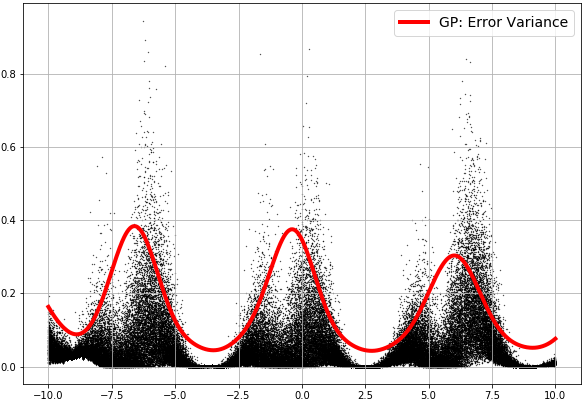

CPU times: user 2.61 s, sys: 8.01 s, total: 10.6 s
Wall time: 2.85 s


In [272]:


%%time


n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]
pred, var = gperror_parallel(gp_numerical.propagate_GA, xt_, Sigma, 
                           n_jobs=n_jobs, batch_size=batch_size, verbose=0)
# for i in range(n_samples):
#     pred[i], var[i] = gp_numerical.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)



fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

for sq_err in squared_error['numerical']:
    ax.scatter(xt, sq_err, s=0.1, color='k')
    
ax.plot(xt, var, linewidth=4, color='r', label='GP: Error Variance')
# ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_numerical_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

MSE: 0.04764
MAE: 0.16848


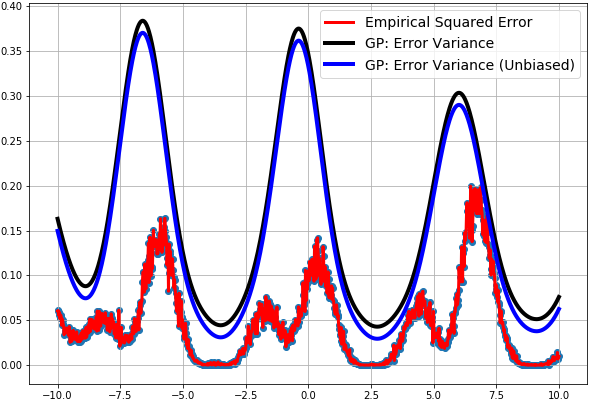

CPU times: user 1.19 s, sys: 6.71 s, total: 7.9 s
Wall time: 1.45 s


In [235]:
%%time


n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]
pred, var = gperror_parallel(gp_numerical.propagate_GA, xt_, Sigma, 
                           n_jobs=n_jobs, batch_size=batch_size, verbose=0)
# for i in range(n_samples):
#     pred[i], var[i] = gp_numerical.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)





fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.scatter(xt, squared_error['numerical'])
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')
ax.plot(xt, var-sigma_y, linewidth=4, color='b', label='GP: Error Variance (Unbiased)')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_numerical_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Q Matrix Optimization

In [276]:
xtrain = np.array([1, 5, 3])[:, np.newaxis]
xtest = np.array([1])[:, np.newaxis]
print(xtrain.shape, xtest.shape)
n_samples = xtrain.shape[0]
d_dimensions = xtrain.shape[1]

(3, 1) (1, 1)


In [216]:
xrow = xtrain[:, np.newaxis, :]
xrow = np.tile(xrow, [1, n_samples, d_dimensions])
print(xrow)
print(xrow.shape)

[[[1]
  [1]
  [1]]

 [[5]
  [5]
  [5]]

 [[3]
  [3]
  [3]]]
(3, 3, 1)


In [217]:
def zterm_matrix(xtrain):
    n_samples, d_dimensions = xtrain.shape
    
    xrow = xtrain[:, np.newaxis, :]
    xrow = np.tile(xrow, [1, n_samples, d_dimensions])
    zterm = 0.5 * (xrow + np.transpose(xrow, axes=(1,0, 2)))
    return zterm

In [94]:
xcol = xrow.copy() #xtrain[:, np.newaxis, :]
xcol = np.transpose(xcol, axes=(1,0, 2))
print(xcol)
print(xcol.shape)



[[[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]]
(3, 3, 1)


In [95]:
zterm = 0.5 * (xrow + xcol)
zterm = zterm_matrix(xtrain)
print(zterm == zterm2)
print(zterm.shape)

NameError: name 'zterm2' is not defined

In [91]:
zterm = zterm_matrix(xtrain)
zterm = zterm - xtest
print(zterm.shape, zterm.T.shape)

(3, 3, 1) (1, 3, 3)


In [95]:
diag_term = np.array([1.0])
print(zterm.shape, diag_term.shape)
exp_term = zterm.dot(diag_term).dot(zterm.T)
print(exp_term.shape)

(3, 3, 1) (1,)
(3, 1, 3)
